# Gender & Age Classification Using Xception

**Xception**, short for ***Extreme Inception*** , is a deep learning model that uses depthwise separable convolutions to classify images: 

**Architecture :**

Xception is a convolutional neural network (CNN) with **71 layers**. It uses depthwise separable convolution layers instead of inception modules, which are used in the Inception architecture. 

**Performance :**

Xception performs slightly better than *~Inception V3~* on the ImageNet dataset, but significantly better on larger datasets.

## Importing the necessary Libraries :

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img , plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')
%matplotlib inline

## Load the Dataset

In [3]:
base_dr = '/kaggle/input/utkface-new/UTKFace'

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(base_dr)):
    image_path = os.path.join(base_dr, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 477344.80it/s]


## Conversion to Dataframe

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1

## Display some images

10it [00:00, 24.65it/s]


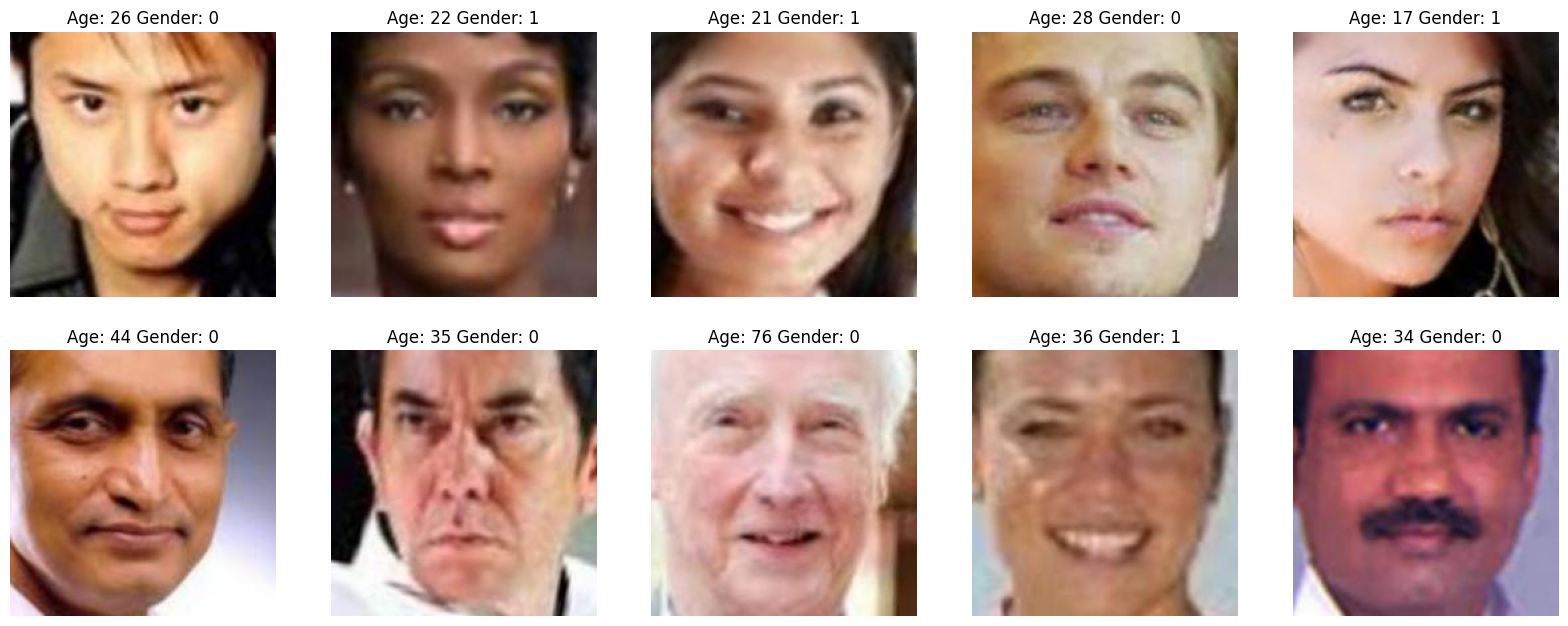

In [6]:
plt.figure(figsize=(20, 20))
files = df.iloc[:10]

for index, file, age, gender in tqdm(files.itertuples()):
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender}")
    plt.axis('off')

Gender : 0 (Male)

Gender : 1 (Female)

## Image Preprocessing

In [7]:
images = df['image'].values
ages = df['age'].values
genders = df['gender'].values

In [8]:
IMG_SIZE = (299, 299)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
def preprocess_image(image_path, age, gender):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0  # Normalize
    return img, {'age': tf.cast(age, tf.float32), 'gender': tf.cast(gender, tf.float32)}

In [10]:
# Prepare the dataset
def create_dataset(image_paths, ages, genders, batch_size, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, ages, genders))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    if is_training:
        dataset = dataset.shuffle(len(image_paths)).repeat()
    return dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [11]:
# Train-test split
X_train, X_test, y_train_age, y_test_age, y_train_gender, y_test_gender = train_test_split(
    image_paths, ages, genders, test_size=0.2, random_state=42
)

In [12]:
train_dataset = create_dataset(X_train, y_train_age, y_train_gender, BATCH_SIZE)
test_dataset = create_dataset(X_test, y_test_age, y_test_gender, BATCH_SIZE, is_training=False)

## Base Model - Xception

In [13]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the base model

In [14]:
# Age prediction head
age_head = GlobalAveragePooling2D()(base_model.output)
age_head = Dense(128, activation='relu')(age_head)
age_head = Dropout(0.5)(age_head)
age_output = Dense(1, name='age')(age_head)

In [15]:
# Gender prediction head
gender_head = GlobalAveragePooling2D()(base_model.output)
gender_head = Dense(128, activation='relu')(gender_head)
gender_head = Dropout(0.5)(gender_head)
gender_output = Dense(1, activation='sigmoid', name='gender')(gender_head)  # Binary classification output

## Concatenation

In [16]:
model = Model(inputs=base_model.input, outputs=[age_output, gender_output])

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'age': 'mean_squared_error', 'gender': 'binary_crossentropy'},
    metrics={'age': 'mae', 'gender': 'accuracy'}
)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 21,386,282 (81.58 MB)

 Trainable params: 524,802 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

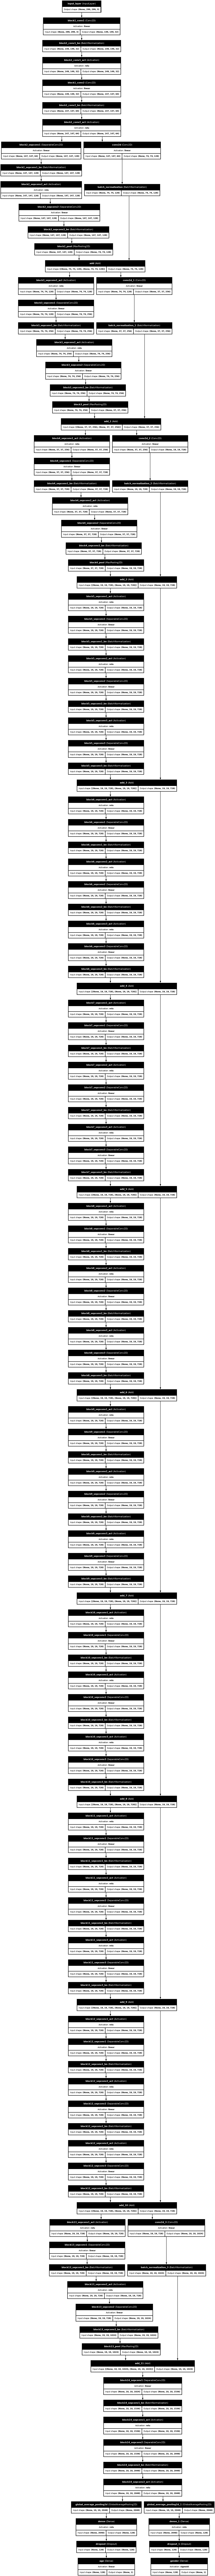

In [19]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=90,
    show_layer_activations=True,
)

## Model Fitting

In [ ]:
EPOCHS = 5
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE
VALIDATION_STEPS = len(X_test) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5


I0000 00:00:1733672133.012853     222 service.cc:145] XLA service 0x78a4ac003040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733672133.012922     222 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733672133.012929     222 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1185 ━━━━━━━━━━━━━━━━━━━━ 15:30:35 47s/step - age_mae: 29.7346 - gender_accuracy: 0.3750 - loss: 1482.4344

I0000 00:00:1733672150.205258     222 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1185/1185 ━━━━━━━━━━━━━━━━━━━━ 224s 149ms/step - age_mae: 18.5782 - gender_accuracy: 0.7866 - loss: 609.9085 - val_age_mae: 11.2311 - val_gender_accuracy: 0.8488 - val_loss: 222.1401
Epoch 2/5
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 153s 129ms/step - age_mae: 11.7543 - gender_accuracy: 0.8533 - loss: 236.3154 - val_age_mae: 14.2524 - val_gender_accuracy: 0.6667 - val_loss: 287.6563
Epoch 3/5
 584/1185 ━━━━━━━━━━━━━━━━━━━━ 1:55 191ms/step - age_mae: 10.9233 - gender_accuracy: 0.8502 - loss: 205.4062